# 📧 Spam Email Detection Project

This notebook implements a spam email detection system using TF-IDF vectorization and multiple machine learning models.

## Models Used:
- RandomForest
- GradientBoosting 
- NaiveBayes

## Evaluation Metric:
- Jaccard Score
- Accuracy Score

## 1. Import Required Libraries

In [ ]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import os
warnings.filterwarnings('ignore')

n_jobs_custom = max(1, int(os.cpu_count() * 0.9))

# Sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, 
    jaccard_score, 
    classification_report, 
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Load and Explore Dataset

In [3]:
# Load the dataset
df = pd.read_csv('email_classification_dataset.csv')

print("📊 Dataset Information:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\n📈 Label Distribution:")
print(df['label'].value_counts())
print(f"\n📧 Sample email length: {len(df.iloc[0]['email'])} characters")

# Display first few rows
df.head()

📊 Dataset Information:
Shape: (10000, 3)
Columns: ['id', 'email', 'label']

📈 Label Distribution:
label
ham     8500
spam    1500
Name: count, dtype: int64

📧 Sample email length: 253 characters


,id,email,label
0,2685,From: support@legitcompany.com\nSubject: Regar...,ham
1,5857,From: noreply@softwareupdates.com\nSubject: We...,ham
2,2399,From: noreply@softwareupdates.com\nSubject: Im...,ham
3,3244,From: info@customerservice.co\nSubject: Team S...,ham
4,2844,From: info@customerservice.co\nSubject: Team S...,ham


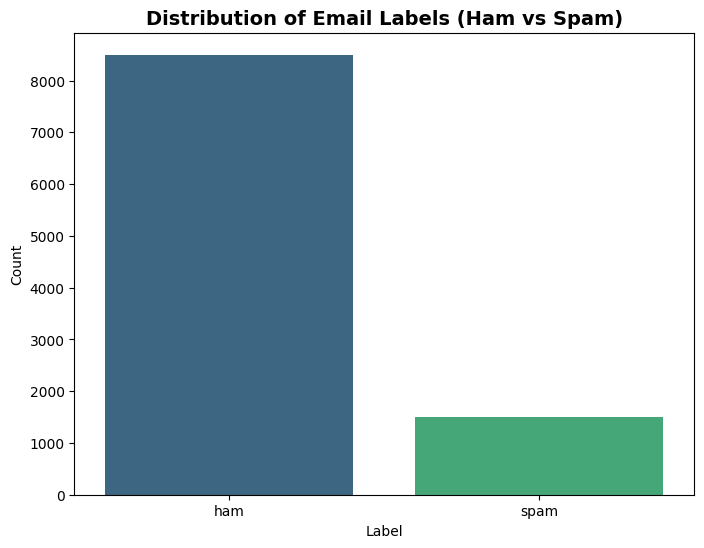


🔍 Missing Values:
id       0
email    0
label    0
dtype: int64


In [4]:
# Visualize label distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label', palette='viridis')
plt.title('Distribution of Email Labels (Ham vs Spam)', fontsize=14, fontweight='bold')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Check for missing values
print("\n🔍 Missing Values:")
print(df.isnull().sum())

## 3. Text Preprocessing Pipeline

In [5]:
def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    
    Steps:
    1. Convert to lowercase
    2. Remove special characters and numbers
    3. Remove extra whitespaces
    4. Tokenize
    5. Remove stopwords
    6. Apply stemming
    """
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove emails, URLs, and special patterns
    text = re.sub(r'\S+@\S+', '', text)  # Remove emails
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(tokens)

# Test preprocessing function
sample_text = df.iloc[0]['email']
print("📧 Original text (first 200 chars):")
print(sample_text[:200])
print("\n🔧 Preprocessed text:")
preprocessed = preprocess_text(sample_text)
print(preprocessed[:200])

📧 Original text (first 200 chars):
From: support@legitcompany.com
Subject: Regarding Your Recent Inquiry

Thank you for reaching out regarding [your inquiry]. We have reviewed your request and will get back to you within 24 hours with 

🔧 Preprocessed text:
subject regard recent inquiri thank reach regard inquiri review request get back within hour detail respons sincer custom servic team


In [6]:
# Apply preprocessing to all emails
print("🔄 Preprocessing all emails...")
df['cleaned_email'] = df['email'].apply(preprocess_text)

# Check the results
print("✅ Preprocessing completed!")
print(f"\n📊 Average email length before preprocessing: {df['email'].str.len().mean():.2f} characters")
print(f"📊 Average email length after preprocessing: {df['cleaned_email'].str.len().mean():.2f} characters")

# Remove empty emails after preprocessing
df = df[df['cleaned_email'].str.len() > 0]
print(f"\n📈 Final dataset shape: {df.shape}")

🔄 Preprocessing all emails...
✅ Preprocessing completed!

📊 Average email length before preprocessing: 246.84 characters
📊 Average email length after preprocessing: 132.99 characters

📈 Final dataset shape: (10000, 4)


## 4. TF-IDF Vectorization

In [ ]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Keep top 5000 features
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95,  # Ignore terms that appear in more than 95% of documents
    sublinear_tf=True  # Apply log scaling
)

# Fit and transform the cleaned emails
print("🔄 Applying TF-IDF vectorization...")
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_email'])
y = df['label']

print(f"✅ TF-IDF vectorization completed!")
print(f"📊 Feature matrix shape: {X_tfidf.shape}")
print(f"📊 Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")
print(f"📊 Sparsity: {(1 - X_tfidf.nnz / X_tfidf.size) * 100:.2f}%")

🔄 Applying TF-IDF vectorization...
✅ TF-IDF vectorization completed!
📊 Feature matrix shape: (10000, 719)
📊 Number of features: 719
📊 Sparsity: 0.00%


## 5. Train-Test Split

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution
)

print("📊 Data Split Information:")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\n📈 Training set label distribution:")
print(y_train.value_counts())
print(f"\n📈 Test set label distribution:")
print(y_test.value_counts())

📊 Data Split Information:
Training set shape: (8000, 719)
Test set shape: (2000, 719)

📈 Training set label distribution:
label
ham     6800
spam    1200
Name: count, dtype: int64

📈 Test set label distribution:
label
ham     1700
spam     300
Name: count, dtype: int64


## 6. Model Training and Evaluation

In [10]:
# Initialize models
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=42,
        n_jobs=n_jobs_custom
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=6,
        random_state=42
    ),
    'NaiveBayes': MultinomialNB(alpha=1.0)
}

# Dictionary to store results
results = {}

print("🚀 Training models...\n")

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    jaccard = jaccard_score(y_test, y_pred, pos_label='spam')  # Using 'spam' as positive class
    f1 = f1_score(y_test, y_pred, pos_label='spam')
    precision = precision_score(y_test, y_pred, pos_label='spam')
    recall = recall_score(y_test, y_pred, pos_label='spam')
    
    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'jaccard': jaccard,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'model': model
    }
    
    print(f"✅ {model_name} Results:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Jaccard Score: {jaccard:.4f}")
    print(f"   F1 Score: {f1:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print("-" * 50)

print("🎉 All models trained successfully!")

🚀 Training models...

Training RandomForest...
✅ RandomForest Results:
   Accuracy: 1.0000
   Jaccard Score: 1.0000
   F1 Score: 1.0000
   Precision: 1.0000
   Recall: 1.0000
--------------------------------------------------
Training GradientBoosting...
✅ GradientBoosting Results:
   Accuracy: 1.0000
   Jaccard Score: 1.0000
   F1 Score: 1.0000
   Precision: 1.0000
   Recall: 1.0000
--------------------------------------------------
Training NaiveBayes...
✅ NaiveBayes Results:
   Accuracy: 1.0000
   Jaccard Score: 1.0000
   F1 Score: 1.0000
   Precision: 1.0000
   Recall: 1.0000
--------------------------------------------------
🎉 All models trained successfully!


## 7. Model Comparison and Best Model Selection

In [11]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'Jaccard Score': [results[model]['jaccard'] for model in results],
    'F1 Score': [results[model]['f1'] for model in results],
    'Precision': [results[model]['precision'] for model in results],
    'Recall': [results[model]['recall'] for model in results]
})

# Sort by Jaccard Score (as requested)
comparison_df = comparison_df.sort_values('Jaccard Score', ascending=False)

print("📊 Model Comparison Results (Sorted by Jaccard Score):")
print(comparison_df.round(4))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_jaccard_score = comparison_df.iloc[0]['Jaccard Score']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"🎯 Best Jaccard Score: {best_jaccard_score:.4f}")

📊 Model Comparison Results (Sorted by Jaccard Score):
              Model  Accuracy  Jaccard Score  F1 Score  Precision  Recall
0      RandomForest       1.0            1.0       1.0        1.0     1.0
1  GradientBoosting       1.0            1.0       1.0        1.0     1.0
2        NaiveBayes       1.0            1.0       1.0        1.0     1.0

🏆 Best Model: RandomForest
🎯 Best Jaccard Score: 1.0000


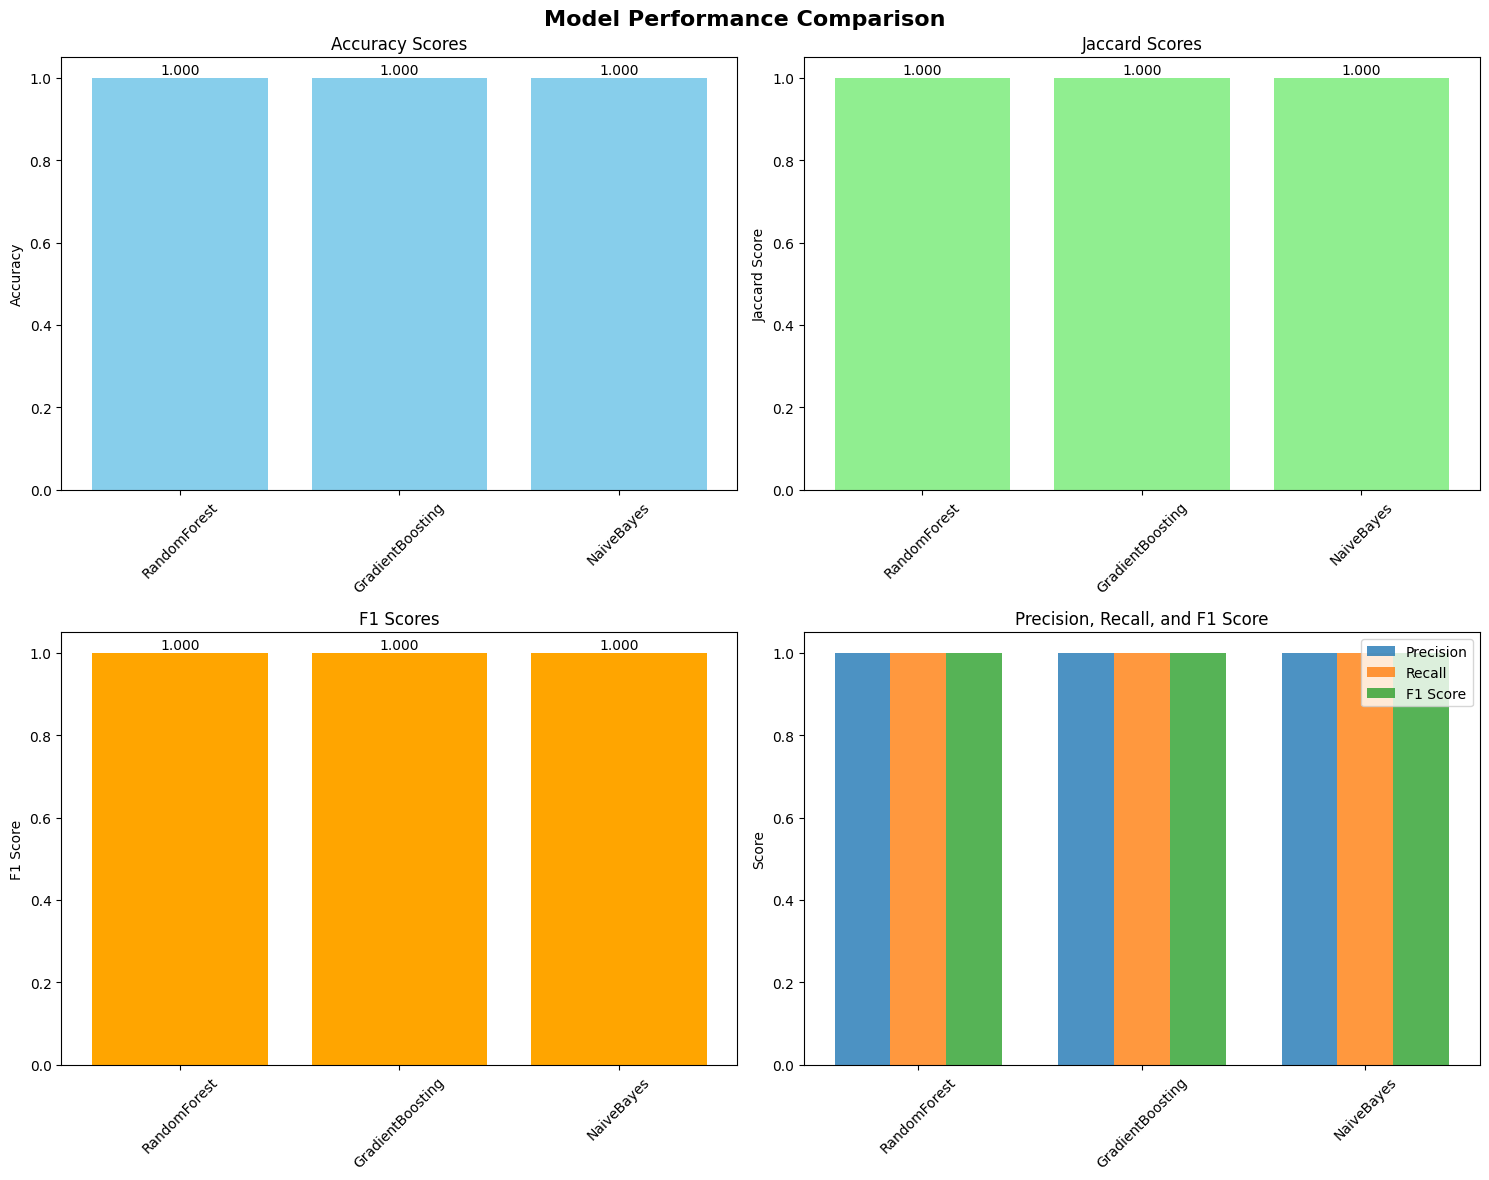

In [12]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Accuracy comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['Accuracy'], color='skyblue')
axes[0, 0].set_title('Accuracy Scores')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Jaccard Score comparison
axes[0, 1].bar(comparison_df['Model'], comparison_df['Jaccard Score'], color='lightgreen')
axes[0, 1].set_title('Jaccard Scores')
axes[0, 1].set_ylabel('Jaccard Score')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Jaccard Score']):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center')

# F1 Score comparison
axes[1, 0].bar(comparison_df['Model'], comparison_df['F1 Score'], color='orange')
axes[1, 0].set_title('F1 Scores')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['F1 Score']):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Combined metrics
x = range(len(comparison_df))
width = 0.25
axes[1, 1].bar([i - width for i in x], comparison_df['Precision'], width, label='Precision', alpha=0.8)
axes[1, 1].bar(x, comparison_df['Recall'], width, label='Recall', alpha=0.8)
axes[1, 1].bar([i + width for i in x], comparison_df['F1 Score'], width, label='F1 Score', alpha=0.8)
axes[1, 1].set_title('Precision, Recall, and F1 Score')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(comparison_df['Model'], rotation=45)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 8. Detailed Analysis of Best Model

📋 Detailed Classification Report for RandomForest:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      1700
        spam       1.00      1.00      1.00       300

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



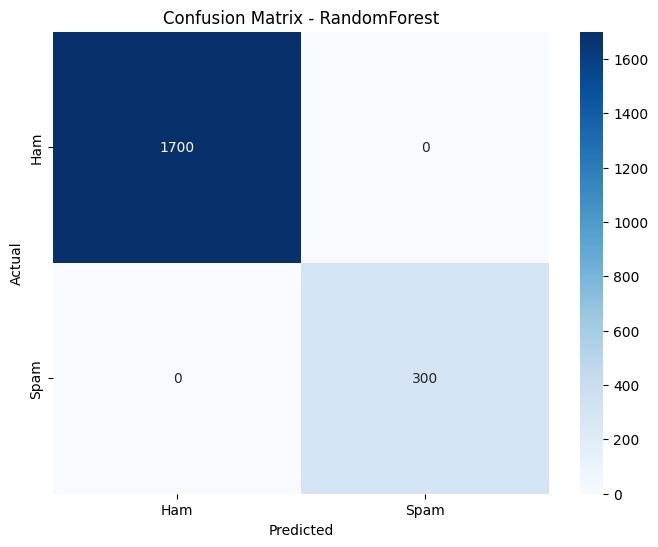

In [13]:
# Get best model
best_model = results[best_model_name]['model']
y_pred_best = best_model.predict(X_test)

# Detailed classification report
print(f"📋 Detailed Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_best))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 9. Feature Importance Analysis (for tree-based models)

🎯 Top 20 Most Important Features for RandomForest:
           feature  importance
358            new    0.052204
77           claim    0.033004
308          login    0.030512
381          offer    0.028421
182         experi    0.022255
141         detect    0.021499
496         requir    0.021037
692         verifi    0.019577
259         invest    0.018527
221         immedi    0.018059
215    high return    0.017775
80           click    0.017644
687         urgent    0.016921
133          delay    0.016900
48            bank    0.016798
382  offer product    0.015599
565         social    0.015456
144          devic    0.015447
214           high    0.014853
423        product    0.014056


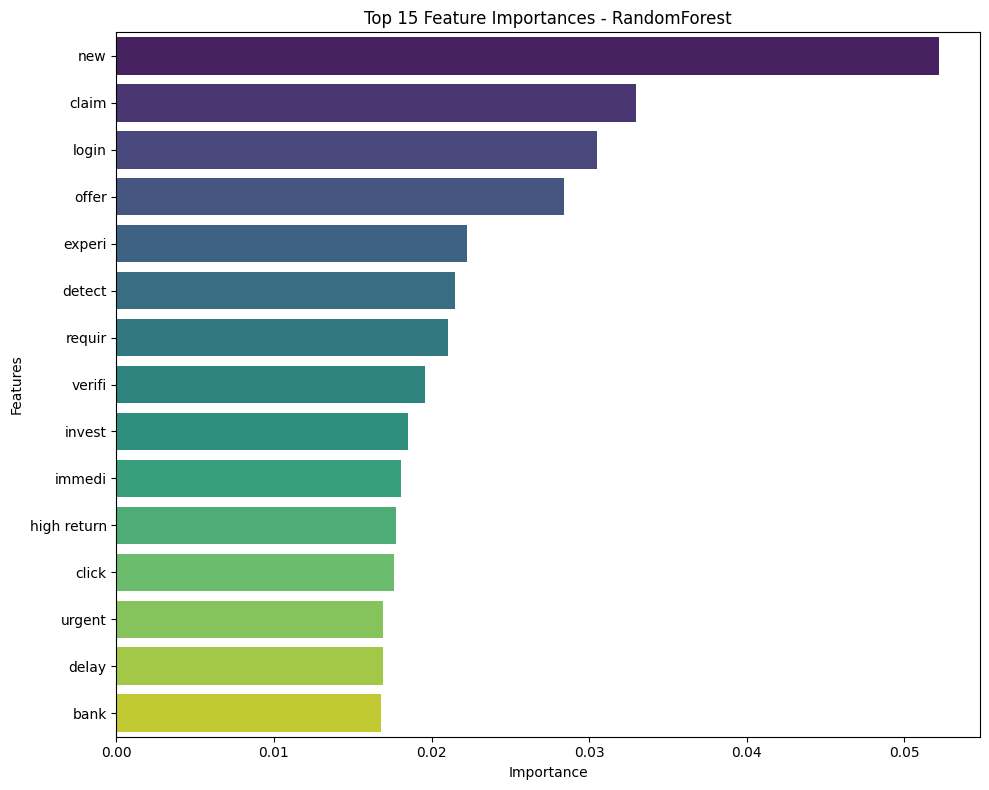

In [ ]:
# Feature importance analysis (only for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Get feature importances
    importances = best_model.feature_importances_
    
    # Create DataFrame for easy sorting
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Display top 20 most important features
    print(f"🎯 Top 20 Most Important Features for {best_model_name}:")
    print(feature_importance_df.head(20))
    
    # Plot top 15 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance_df.head(15)
    sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️ Feature importance not available for {best_model_name}")

## 10. Model Testing Function

In [15]:
def predict_email(email_text, model=best_model, vectorizer=tfidf_vectorizer):
    """
    Predict whether an email is spam or ham
    
    Args:
        email_text (str): The email text to classify
        model: Trained model to use for prediction
        vectorizer: Fitted TF-IDF vectorizer
        
    Returns:
        tuple: (prediction, probability)
    """
    # Preprocess the email
    cleaned_email = preprocess_text(email_text)
    
    # Vectorize
    email_tfidf = vectorizer.transform([cleaned_email])
    
    # Predict
    prediction = model.predict(email_tfidf)[0]
    probability = model.predict_proba(email_tfidf)[0]
    
    return prediction, probability

# Test with sample emails
test_emails = [
    "Congratulations! You've won $1000000! Click here to claim your prize now!",
    "Hi, this is a reminder about your appointment tomorrow at 2 PM. Please confirm.",
    "URGENT: Your account will be suspended unless you verify your details immediately!"
]

print("🧪 Testing the best model with sample emails:\n")
for i, email in enumerate(test_emails, 1):
    prediction, probability = predict_email(email)
    spam_prob = probability[1] if prediction == 'spam' else probability[0]
    
    print(f"Email {i}: {email[:50]}...")
    print(f"Prediction: {prediction.upper()}")
    print(f"Confidence: {spam_prob:.2%}")
    print("-" * 60)

🧪 Testing the best model with sample emails:

Email 1: Congratulations! You've won $1000000! Click here t...
Prediction: SPAM
Confidence: 53.00%
------------------------------------------------------------
Email 2: Hi, this is a reminder about your appointment tomo...
Prediction: HAM
Confidence: 99.00%
------------------------------------------------------------
Email 3: URGENT: Your account will be suspended unless you ...
Prediction: SPAM
Confidence: 56.00%
------------------------------------------------------------


## 11. Final Summary

In [16]:
print("📋 SPAM EMAIL DETECTION PROJECT SUMMARY")
print("=" * 50)
print(f"📊 Dataset Size: {df.shape[0]} emails")
print(f"🔧 Preprocessing: Text cleaning, tokenization, stemming")
print(f"🎯 Vectorization: TF-IDF with {X_tfidf.shape[1]} features")
print(f"🤖 Models Tested: {', '.join(models.keys())}")
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"🎯 Jaccard Score: {best_jaccard_score:.4f}")
print(f"📈 Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"🎪 F1 Score: {results[best_model_name]['f1']:.4f}")
print("\n" + "="*50)
print("✅ Project completed successfully!")

📋 SPAM EMAIL DETECTION PROJECT SUMMARY
📊 Dataset Size: 10000 emails
🔧 Preprocessing: Text cleaning, tokenization, stemming
🎯 Vectorization: TF-IDF with 719 features
🤖 Models Tested: RandomForest, GradientBoosting, NaiveBayes

🏆 BEST MODEL: RandomForest
🎯 Jaccard Score: 1.0000
📈 Accuracy: 1.0000
🎪 F1 Score: 1.0000

✅ Project completed successfully!
